In [1]:
import json
import re
import sqlite3
from sqlite3 import Connection

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
cursor = conn.cursor()

cursor.execute("SELECT id, entities FROM tweets;")
rows = cursor.fetchall()

for row_id, entities in rows:
    try:
        if entities is not None and "nan" not in entities:
            corrected_entities = re.sub(r"(?<!\\)'", '"', entities)
            py_dict = json.loads(corrected_entities)
            valid_json = json.dumps(py_dict)
            cursor.execute(
                "UPDATE tweets SET entities = ? WHERE id = ?", (valid_json, row_id)
            )
    except Exception as e:
        print(f"Error on row {row_id}: {e} for entities {entities}")
        
conn.commit()
conn.close()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def clean_to_json(py_dict_str):
    try:
        # Fix unescaped single quotes
        fixed_str = re.sub(r"(.,?<!\\)'", '"', py_dict_str)
        
        # Replace Python-style literals with JSON-style literals
        fixed_str = fixed_str.replace("None", "null").replace("True", "true").replace("False", "false")
        
        # Decode JSON to validate
        py_dict = json.loads(fixed_str)
        
        # Convert back to JSON string
        return json.dumps(py_dict)
    except Exception as e:
        print(f"Failed to clean row: {e}")
        return None

In [ ]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
cursor = conn.cursor()

cursor.execute("SELECT id, entities FROM tweets;")
rows = cursor.fetchall()

invalid_rows = []

for row_id, entities in rows:
    try:
        if entities is not None and "nan" not in entities:
            json.loads(entities)
    except json.JSONDecodeError:
        invalid_rows.append((row_id, entities))
        
print("Found {} invalid rows.".format(len(invalid_rows)))

for row_id, entities in invalid_rows:
    try:
        cleaned_entities = clean_to_json(entities)
        if cleaned_entities:  # Only update if cleaning was successful
            cursor.execute(
                "UPDATE tweets SET entities = ? WHERE id = ?",
                (cleaned_entities, row_id)
            )
    except Exception as e:
        print(f"Error updating row {row_id}: {e}")

        
conn.commit()
conn.close()

Found 0 invalid rows.


In [ ]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
cursor = conn.cursor()

try:
    cursor.execute("""
        UPDATE tweets
        SET entities = REPLACE(
            REPLACE(
                REPLACE(entities, "'", '"'),
                'True', 'true'
            ),
            'False', 'false'
        )
        WHERE json_valid(entities) = 0;
    """)
    
    # Commit the changes
    conn.commit()
    print("Invalid rows updated successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Invalid rows updated successfully.


In [2]:
def common_urls_as_dataframe(db: Connection, seconds_between: int, save_csv: bool = False):
    cur = db.cursor()

    cur.execute("""
        CREATE TEMP TABLE tweet_urls AS
        SELECT
            tweets.id,
            tweets.text,
            tweets.author_id,
            json_extract(value, '$.expanded_url') AS url,
            tweets.lang,
            datetime(created_at) AS created_at
        FROM tweets,
            json_each(json_extract(entities, '$.urls'))
        WHERE
            entities IS NOT NULL AND
            entities != 'nan' AND
            json_valid(entities) = 0 and
            json_extract(entities, '$.urls') IS NOT NULL
        AND text NOT LIKE 'RT @%'
    """)

    # Create indexes for speed
    cur.execute("CREATE INDEX temp.idx_tweet_urls_url ON tweet_urls(url)")
    cur.execute("CREATE INDEX temp.idx_tweet_urls_id ON tweet_urls(id)")
    cur.execute("CREATE INDEX temp.idx_tweet_urls_author ON tweet_urls(author_id)")
    cur.execute("CREATE INDEX temp.idx_tweet_urls_combined ON tweet_urls(url, id, author_id)")

    res = cur.execute("""
        SELECT
            t1.id AS id1,
            t2.id AS id2,
            t1.url,
            t1.text AS text1,
            t2.text AS text2,
            t1.lang as lang1,
            t2.lang as lang2,
            t1.author_id AS author1,
            t2.author_id AS author2,
            t1.created_at AS time1,
            t2.created_at AS time2,
            abs(julianday(t1.created_at) - julianday(t2.created_at)) * 86400 AS seconds_diff
        FROM tweet_urls t1
        JOIN tweet_urls t2 ON
            t1.url = t2.url AND
            t1.id < t2.id AND
            t1.author_id < t2.author_id
        WHERE
            abs(julianday(t1.created_at) - julianday(t2.created_at)) * 86400 <= ?
    """, [seconds_between])
    rows = res.fetchall()
    cur.execute("DROP TABLE tweet_urls")
    print(f"Found {rows} entries")
    df = pd.DataFrame(rows)
    if save_csv:
        df.to_csv(f"df_url_connections_s{seconds_between}.csv")

    return df

In [3]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
bots_df = common_urls_as_dataframe(db=conn, seconds_between=1, save_csv=True)
print(bots_df.head())

OperationalError: malformed JSON

In [14]:
conn = sqlite3.connect(f"D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
cur = conn.cursor()
result = cur.execute("""
                    SELECT id, entities
                    FROM tweets
                    WHERE json_valid(entities) = 0
                    """
                )
test_df = pd.DataFrame(result.fetchall())
conn.close()

In [ ]:
print(test_df.head())

                    0                                                  1
0  675827469119832066  {"mentions": [{"start": 3, "end": 15, "usernam...
1  675827469006581760  {"mentions": [{"start": 3, "end": 19, "usernam...
2  675827468775718912  {"mentions": [{"start": 3, "end": 11, "usernam...
3  675827465378504705  {"mentions": [{"start": 3, "end": 18, "usernam...
4  675827465336434688  {"mentions": [{"start": 3, "end": 15, "usernam...


In [ ]:
print(test_df.head(10))
len(test_df)

                    0    1
0  675825304557002752  nan
1  675824250536763392  nan
2  675817141174693888  nan
3  675814741428723712  nan
4  675810767330017280  nan
5  675810146061127680  nan
6  675807030461005824  nan
7  675804439924600833  nan
8  675804270017556480  nan
9  675802325651468288  nan


1126

In [ ]:
conn.close()

In [7]:
def analyze_graph(g: ig.Graph):
    order = g.vcount()
    size = g.ecount()
    components = g.components()
    no_components = len(components)
    size_of_largest_component = max([len(component) for component in components])
    density = g.density()
    transitivity = g.transitivity_avglocal_undirected()
    
    print(f"Order: {order}")
    print(f"Size: {size}")
    print(f"No .of Components: {no_components}")
    print(f"Size of largest component: {size_of_largest_component}")
    print(f"Density: {density}")
    print(f"Transitivity: {transitivity}")
    
    degree_dist = g.degree()
    degree_counts = np.bincount(degree_dist)
    degrees = np.arange(len(degree_counts))
    
    non_zero = degree_counts > 0
    degrees = degrees[non_zero]
    degree_counts = degree_counts[non_zero]
    
    plt.figure(figsize=(8, 6))
    plt.loglog(degrees, degree_counts, marker="o", linestyle="", markersize=6, alpha=0.7, label="Degree Distribution")
    plt.title("Degree Distribution (Log-Log Scale)")
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.grid(which="both", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

In [8]:
def prepare_graph(g: ig.Graph):
    layout = g.layout("fr") # circle
    
    g.vs["color"] = "red"
    g.vs["size"] = 1
    g.vs["frame_width"] = 0
    g.vs["label"] = None
    
    g.es["color"] = "rgba(0, 0, 0, 0.1)"
    g.es["width"] = 0.5
    
    return g, layout

In [9]:
def plot_graph(g: ig.Graph, layout: ig.Layout, target_file = None):
    visual_style = {
        "layout": layout,
        "vertex_color": g.vs["color"],
        "vertex_size": g.vs["size"],
        "vertex_frame_width": 0,
        "vertex_label": None,
        "edge_color": g.es["color"],
        "edge_width": g.es["width"],
        # "bbox": (800, 800),  # Image size in pixels
        "margin": 2,
    }

    # Use matplotlib as the engine for visualization
    plt.figure(figsize=(10, 10))
    ig_plot = ig.plot(g, target=target_file, **visual_style, backend="matplotlib")

    if target_file is None:
        plt.show()  # Show plot interactively
    else:
        print(f"Plot saved to: {target_file}")

In [2]:
bots_df = pd.read_csv("D:/UU/Sem3/SDM/social_data_mining/data/df_url_connections_s1.csv")
bots_df[["author1", "author2"]] = bots_df[["author1", "author2"]].astype(str)
print(bots_df.dtypes)


Unnamed: 0        int64
id1               int64
id2               int64
url              object
text1            object
text2            object
lang1            object
lang2            object
author1          object
author2          object
time1            object
time2            object
seconds_diff    float64
dtype: object


In [3]:
authors = set(bots_df["author1"])
authors.update(bots_df["author2"])
authors = list(authors)
print(authors)
print(len(authors))

['537126156', '94261637', '2205561872', '57444993', '465390697', '3980712313', '529414058', '88189762', '2233963809', '206637380', '3937983196', '135844272', '109574714', '160891807', '285854591', '472392562', '2315974117', '169005364', '2321895398', '3090137307', '454514466', '424325660', '1663110084', '2491354009', '2800175242', '255170508', '45545559', '386125816', '4053625758', '409076663', '85440933', '1119213548', '472852148', '434230090', '263466153', '2387411994', '96752543', '409857378', '1439356548', '429854485', '513233852', '722210166', '310319345', '305872446', '113410319', '51111741', '245228322', '235533715', '1133094565', '2306096600', '871918220', '473508531', '427494915', '383150234', '62902318', '400802013', '531962072', '2423795893', '586443220', '2401336838', '314668623', '100731315', '406814336', '7682502', '481432034', '412288316', '2300508674', '19117373', '57095210', '126352024', '713356466', '110430185', '40473961', '89386530', '64805888', '196903691', '409418

In [15]:
r = 3
df_interactions = bots_df.groupby(["author1", "author2", "url"]).size().reset_index(name="count")
df_interactions = df_interactions[df_interactions["count"] >= r]
print(df_interactions.head(10))
print(df_interactions.info())
print(df_interactions.describe())

        author1     author2  \
47   1022779850  4339043357   
62     10340482   122190432   
74     10340482   145394310   
76     10340482   145394310   
105   104561644  4339043357   
304  1131838608  4339043357   
315  1133094565  2492097511   
317  1133094565  2802672601   
352  1151068046  2617471956   
366   115702663    20582958   

                                                   url  count  
47                               http://bit.ly/1Obe5EY     12  
62                               http://bit.ly/1HF4zcq      3  
74                               http://bit.ly/1j8sYuP      3  
76                               http://bit.ly/1jKTQS6      3  
105                              http://bit.ly/1Obe5EY      5  
304                              http://bit.ly/1Obe5EY      4  
315                                 http://ow.ly/VBinU      3  
317                                 http://ow.ly/VBinU      3  
352                              http://bit.ly/1Obe5EY      3  
366  http://www.th

In [16]:
bot_graph = ig.Graph(n=len(authors))
bot_graph["title"] = "Possible Bot Network"
bot_graph.vs["name"] = authors
bot_graph.vs["text1"] = bots_df["text1"]
bot_graph.vs["text2"] = bots_df["text2"]
bot_graph.vs["url"] = bots_df["url"]
# edge_list = interactions_df[["author1", "author2"]].apply(tuple, axis=1).tolist()
bot_graph.add_edges(df_interactions[["author1", "author2"]].apply(tuple, axis=1).tolist())
bot_graph.delete_vertices([v.index for v in bot_graph.vs if v.degree() < 1])
bot_graph.summary()

'IGRAPH UN-- 152 768 -- \n+ attr: title (g), name (v), text1 (v), text2 (v), url (v)'

Order: 152
Size: 768
No .of Components: 37
Size of largest component: 26
Density: 0.06692227256883931
Transitivity: 0.7441965994204799


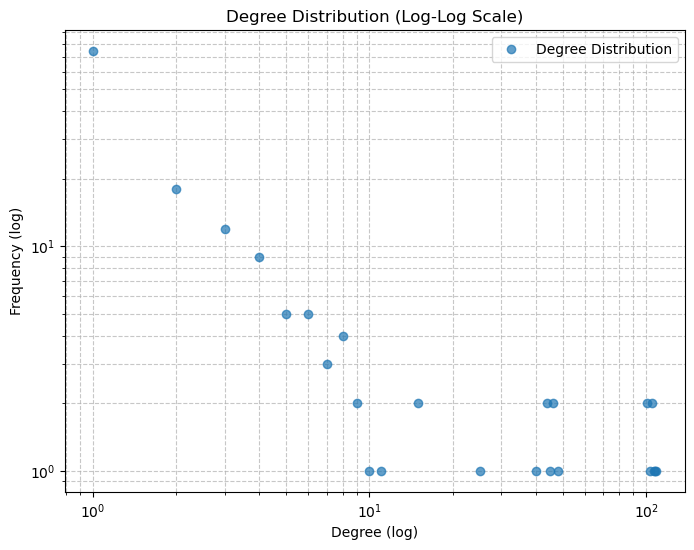

In [17]:
bot_graph, bot_layout = prepare_graph(bot_graph)
analyze_graph(bot_graph)

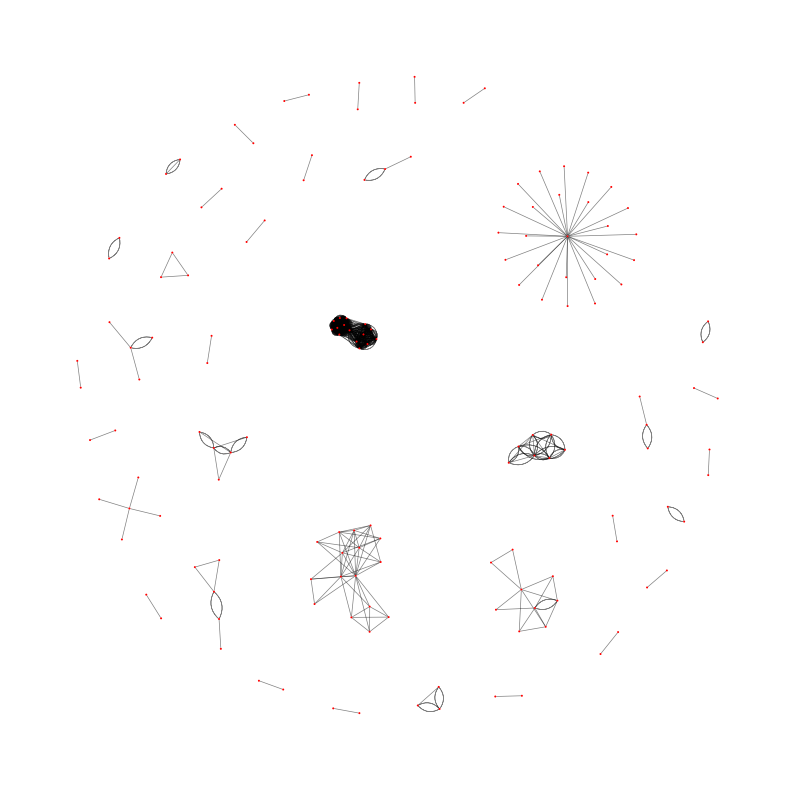

In [18]:
bot_graph.vs["size"] = 2
bot_graph.es["width"] = .5
bot_graph.es["color"] = "rgba(1, 1, 1, .5)"
plot_graph(bot_graph, layout=bot_layout)

In [19]:
for component in bot_graph.components():
    if len(component) > 7:
        print(f"Component len={len(component)}")
        for field in bot_graph.vs[component]["text1"]:
            print(f"Field: {field}")

Component len=15
Field: #COP21 : "Un matin, nous avons oublié la délégation allemande…" https://t.co/YqYKSjs5tZ par @juliettedemey #JDD https://t.co/j8yK97y8bQ
Field: #redline  #COP21 #London #olsx https://t.co/FZQbGkMzL7
Field: +Le but de la #COP21 est de reduire la température moyenne de la planète en-dessous de 2°C d’ici #sassoui #NRCG ² https://t.co/Fa4GtCVzIw
Field: Le but de la #COP21 est de reduire la température moyenne de la planète en-dessous de 2°C d’ici #sassoui #NRCG ² https://t.co/1dV544JfQL =
Field: #COP21 : Denis Sassou N’Guesso a aussi parlé au nom de l’Afrique #sassoui #NRCG @moungalla @congosouverain https://t.co/W2kdfXi9AU ''
Field: #COP21 : Denis Sassou N’Guesso a aussi parlé au nom de l’Afrique #sassoui #NRCG @moungalla @congosouverain https://t.co/nB5Cv7R5Hw d
Field: #COP21 : Denis Sassou N’Guesso a aussi parlé au nom de l’Afrique #sassoui #NRCG @moungalla @congosouverain https://t.co/W2kdfXi9AU pp
Field: La #COP21  doit aboutir à un accord « universel et contrai